In [1]:
from itertools import product
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

viridis = mpl.colormaps["viridis"]


def color_p(p):
    return viridis(p / 7)

/tmp/ipykernel_4136687/904872224.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["n_f_cells_updated_per_s"] = filtered_df.n_cells_updated_per_s * n_f_evaluations
/tmp/ipykernel_4136687/904872224.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["n_f_cells_updated_per_s"] = filtered_df.n_cells_updated_per_s * n_f_evaluations
/tmp/ipykernel_4136687/904872224.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

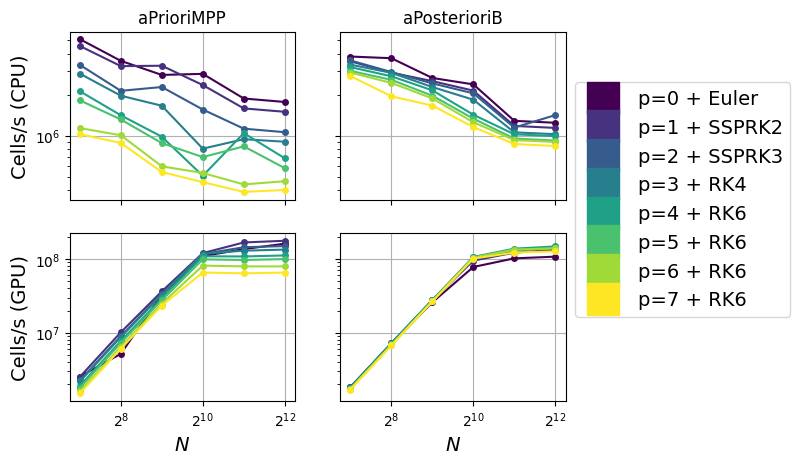

In [2]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey="row")

make_legend = True

df = pd.read_csv("data/timing.csv")

for p, df_p in df.groupby("p"):
    for scheme, df_lim in df_p.groupby("scheme"):
        for device, df_dev in df_lim.groupby("device"):
            filtered_df = df_dev[df_dev.n >= 128]
            i = int(device == "gpu")
            j = {"aPrioriFixedDt": 0, "aPosterioriB": 1}[scheme]
            integrator_name = {
                "euler": "Euler",
                "ssprk2": "SSPRK2",
                "ssprk3": "SSPRK3",
                "rk4": "RK4",
                "rk6": "RK6",
            }[df_dev.integrator.to_list()[0]]
            n_f_evaluations = {
                "Euler": 1,
                "SSPRK2": 2,
                "SSPRK3": 3,
                "RK4": 4,
                "RK6": 7,
            }[integrator_name]
            filtered_df["n_f_cells_updated_per_s"] = (
                filtered_df.n_cells_updated_per_s * n_f_evaluations
            )
            axs[i, j].plot(
                filtered_df.n,
                filtered_df.n_f_cells_updated_per_s,
                marker="o",
                markersize=4,
                color=color_p(p),
                label=f"{p=} + {integrator_name}",
            )

# cosmetics
fontsize = 14
axs[0, 0].set_yscale("log")
axs[1, 0].set_yscale("log")
axs[1, 0].set_xscale("log", base=2)
axs[1, 0].set_xlabel("$N$", fontsize=fontsize)
axs[1, 1].set_xlabel("$N$", fontsize=fontsize)
axs[0, 0].set_ylabel("Cells/s (CPU)", fontsize=fontsize)
axs[1, 0].set_ylabel("Cells/s (GPU)", fontsize=fontsize)
for i, j in product((0, 1), (0, 1)):
    axs[i, j].grid()
axs[0, 0].set_title("aPrioriMPP")
axs[0, 1].set_title("aPosterioriB")

# legend
if make_legend:
    legend = axs[0, 1].legend(
        loc="center left", bbox_to_anchor=(1.0, 0), fontsize=fontsize
    )
    for line in legend.get_lines():
        line.set_linestyle("none")
        line.set_marker("s")
    for handle, p in zip(legend.legendHandles, [0, 1, 2, 3, 4, 5, 6, 7]):
        if p == -1:
            handle.set_markerfacecolor("grey")
        else:
            handle.set_markerfacecolor(color_p(p))
        handle.set_markersize(1.6 * fontsize)

plt.savefig("images/images_timing.png", dpi=300, bbox_inches="tight")

In [52]:
from configs import limiting_schemes_2d, problem_configs, timing_solver_config
from finite_volume.advection import AdvectionSolver

limiting_schemes = limiting_schemes_2d

N = 64
p = 3
lckey = "aPosterioriB"
cupy = False
n_steps = 10

nolimiting = {"flux_strategy": "transverse", "courant": 0.8}

ratios = []

for trial in range(10):
    solver = AdvectionSolver(
        n=(N,),
        order=p + 1,
        cupy=cupy,
        snapshot_dt=1.0,
        num_snapshots=1,
        **limiting_schemes[lckey],
        **problem_configs["square2d"],
        **timing_solver_config,
        load=False,
    )
    solver.snapshot_dt = 0
    for _ in range(n_steps):
        solver.snapshot_dt += solver.dt
    solver.rkorder(rk6=True if p > 3 else False)

    solver_unlimited = AdvectionSolver(
        n=(N,),
        order=p + 1,
        cupy=cupy,
        snapshot_dt=1.0,
        num_snapshots=1,
        **nolimiting,
        **problem_configs["square2d"],
        **timing_solver_config,
        load=False,
    )
    solver_unlimited.snapshot_dt = 0
    for _ in range(n_steps):
        solver_unlimited.snapshot_dt += solver_unlimited.dt
    solver_unlimited.rkorder(rk6=True if p > 3 else False)

    ratios.append(solver_unlimited.solution_time / solver.solution_time)

New solution instance...

Wrote a solution up to t = 0.041666666666666664 located at /scratch/gpfs/jp7427/data/square_p_None_(64,)_(0, 1)_(0, 1)_0_1.0_1_(2, 1)_0.8_4_t_F_F_F_PP_T_F_F_F_T_1e-05_(0, 1)_None_F_1e-10_numpy_rk4_0.041666666666666664.pkl

New solution instance...

Wrote a solution up to t = 0.041666666666666664 located at /scratch/gpfs/jp7427/data/square_p_None_(64,)_(0, 1)_(0, 1)_0_1.0_1_(2, 1)_0.8_4_t_F_F_F_mi_F_F_F_F_F_1e-05_(0, 1)_None_F_1e-10_numpy_rk4_0.041666666666666664.pkl

New solution instance...

Wrote a solution up to t = 0.041666666666666664 located at /scratch/gpfs/jp7427/data/square_p_None_(64,)_(0, 1)_(0, 1)_0_1.0_1_(2, 1)_0.8_4_t_F_F_F_PP_T_F_F_F_T_1e-05_(0, 1)_None_F_1e-10_numpy_rk4_0.041666666666666664.pkl

New solution instance...

Wrote a solution up to t = 0.041666666666666664 located at /scratch/gpfs/jp7427/data/square_p_None_(64,)_(0, 1)_(0, 1)_0_1.0_1_(2, 1)_0.8_4_t_F_F_F_mi_F_F_F_F_F_1e-05_(0, 1)_None_F_1e-10_numpy_rk4_0.041666666666666664.pkl

New 

In [53]:
ratios

[0.988037727168162,
 1.0034169622462812,
 1.011097183306297,
 0.9840977226598142,
 0.9846725456902375,
 1.003016686327657,
 1.0754623677183266,
 1.0080139932532528,
 0.9866455696202532,
 0.8971348531228606]

In [54]:
np.mean(ratios)

0.9941595611113142